## Boilerplate

In [1]:
from bs4 import BeautifulSoup
from cycler import cycler
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
import json
from datetime import datetime, date, timedelta
import requests
import seaborn as sns

import pyspark.sql.functions as F
from pyspark.sql.functions import col, udf
from pyspark.sql.types import *

from IPython.core.interactiveshell import InteractiveShell
from IPython.core.display import display, HTML
InteractiveShell.ast_node_interactivity = "all"
display(HTML('<style>.container {width:90% !important;}</style>'))

plt.style.use('fivethirtyeight')
%matplotlib inline

spark.sql('USE football_games')

os.chdir('../football_data')

### Matplotlib Boilerplate

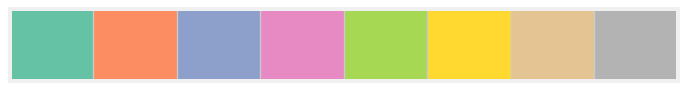

In [2]:
rcParams['axes.titlesize'] = 14
rcParams['axes.titleweight'] = 'bold'
rcParams['figure.titlesize'] = 14
rcParams['figure.titleweight'] = 'bold'
rcParams['text.color'] = '#262626'

rcParams['axes.labelsize'] = 12
rcParams['axes.labelcolor'] = '#262626'
rcParams['axes.labelweight'] = 'bold'

rcParams['legend.fontsize'] = 12

rcParams['figure.figsize'] = (12,8)

rcParams['figure.dpi'] = 96

## colors
color_palette = 'Set2'
colors = sns.color_palette(color_palette)
sns.palplot(sns.color_palette(color_palette))
rcParams['axes.prop_cycle'] = cycler(color=colors)

## Form and explore labels
* might require 2 tables
  * 1. each row is a game
  * 2. each row is a team (predicting individual scores?)
* when each row is a game, in which direction does the spread/ML go?
  * if it's random, then (-inf, inf)
  * if the favorite, then (-inf, 0)
  * if the favorite, then does that mess up predicting straight up who will win?
* labels of interest (-1, 0, 1 which factors in pushes?)
  * game table
    * binary did win
    * winning margin
    * binary did cover
    * binary is_over
  * team table
    * score
* explore
  * team correlations with labels, e.g. which teams cover most/least
  * home/visitor correlation with labels
  * 

#### Prep data

In [3]:
game = spark.table('game')\
                .select('game_id','season','week_id','is_neutral',
                       'h_team_id','v_team_id')\
                .cache()

game_outcome = spark.table('game_outcome')\
                .select('game_id','h_final','v_final')

meta = spark.table('game_metadata')\
                .select('game_id','day_of_week')

lines = spark.table('game_line').select(
        'game_id','h_ml','v_ml',
        'close_fav','close_spread','close_ou','pfr_fav','pfr_spread',
        'pfr_ou','pfr_fav_id'
    )

df = game.join(game_outcome, on='game_id')\
         .join(meta, on='game_id')\
         .join(lines, on='game_id')\
         .cache()

assert game.count() == df.count()
assert game_outcome.count() == df.count()
assert meta.count() == df.count()
assert lines.count() == df.count()

In [34]:
df.limit(5).toPandas().T

,0,1,2,3,4
game_id,201511150ram,201511090sdg,201510180det,201512270tam,201510110kan
season,2015,2015,2015,2015,2015
week_id,10,9,6,16,5
is_neutral,0,0,0,0,0
h_team_id,ram,sdg,det,tam,kan
v_team_id,chi,chi,chi,chi,chi
h_final,13,19,37,21,17
v_final,37,22,34,26,18
day_of_week,6,0,6,6,6
h_ml,-380,-200,-200,-165,-428


### Form Over/Under labels
* #### Hive table: __over_unders__
* single DF
* right now only need: game_id, is_close_over, is_pfr_over
* {-1, 0, 1} where -1 is under, 0 is push, 1 is over
* The O/U hits right about 50%

In [5]:
ou_df = df.withColumn(
        'tot_score', col('h_final') + col('v_final')
    ).select(
        'game_id','close_ou','pfr_ou','tot_score',
        
    )

for ou_col in ['close_ou','pfr_ou']:
    ou_df = ou_df.withColumn(
        'is_{}_over'.format(ou_col),
        F.when(col(ou_col) > col('tot_score'), 1)
         .when(col(ou_col) < col('tot_score'), -1)
         .otherwise(0)
    )

In [77]:
ou_df.select(
    'game_id','close_ou','pfr_ou','tot_score',
    'is_close_ou_over','is_pfr_ou_over'
).write.mode('overwrite').saveAsTable('over_unders')

#### Visualizing Over/Unders

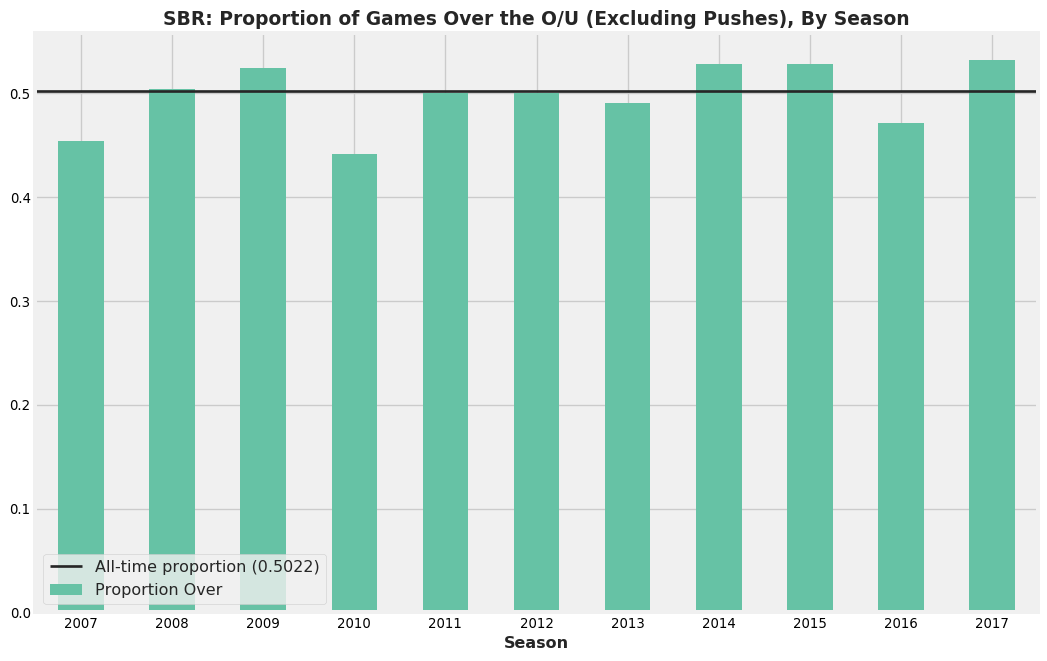

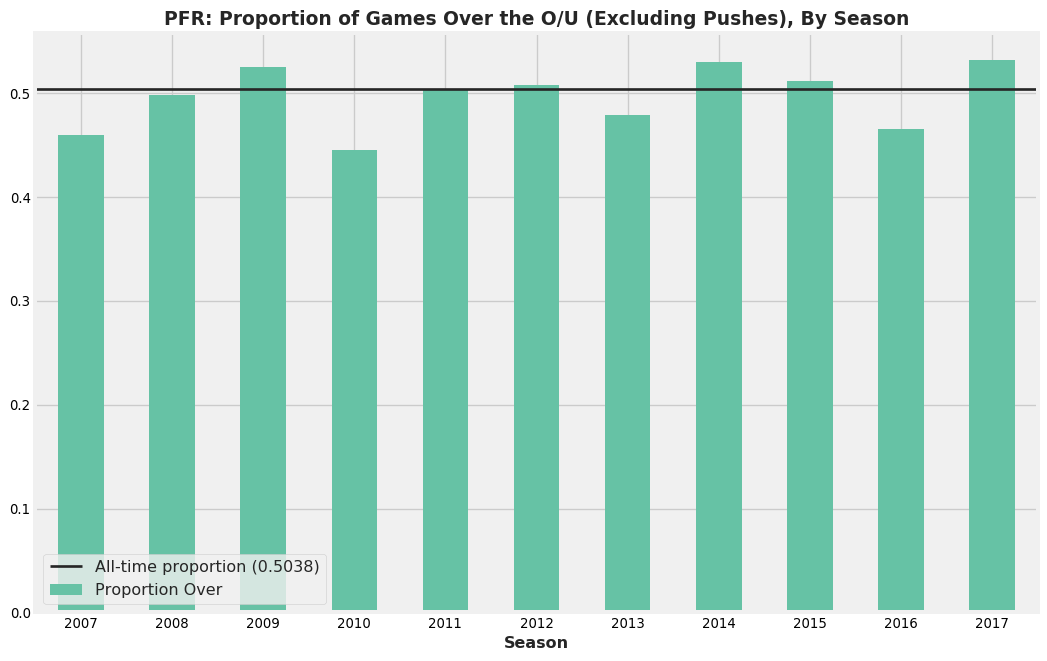

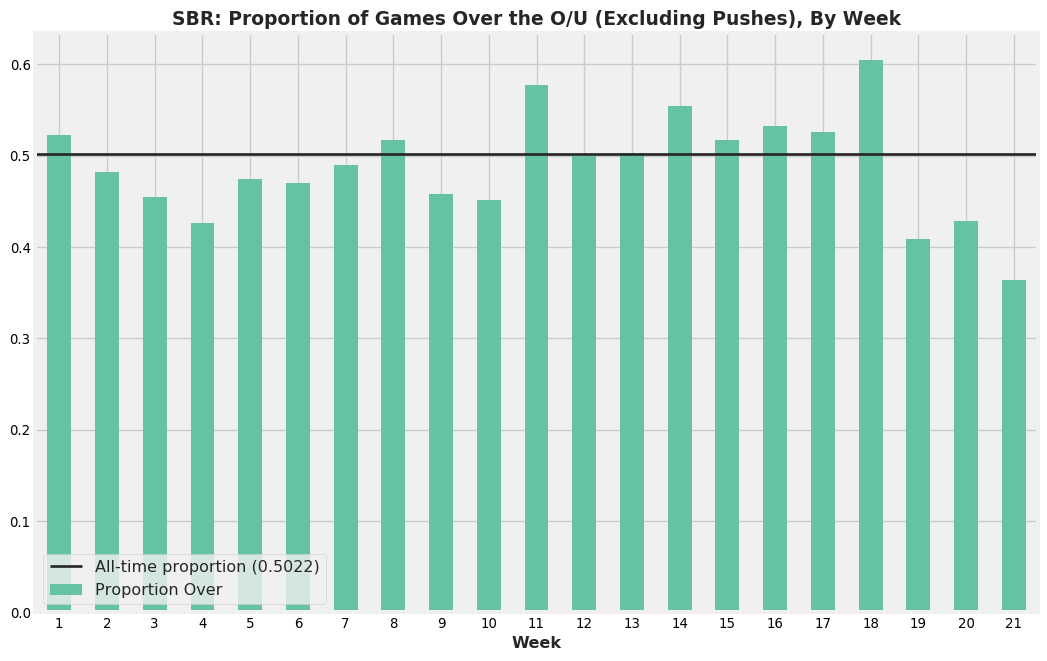

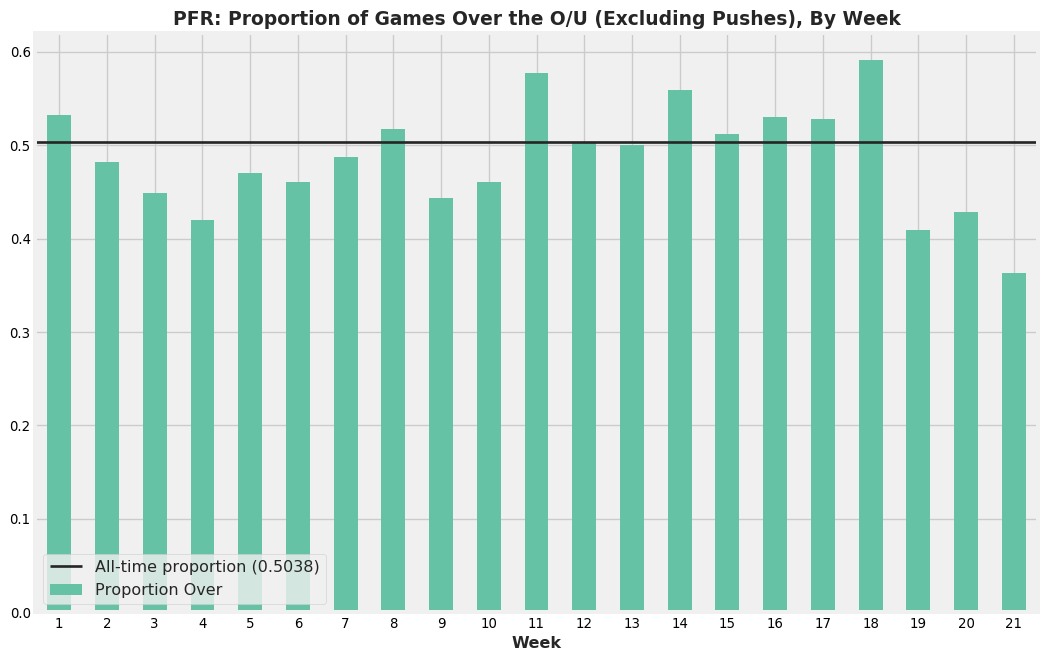

In [78]:
for time_dim, time_str in [('season','Season'),('week_id','Week')]:
    for ou_field, ou_name in [('close_ou','SBR'), ('pfr_ou','PFR')]:
        curr = ou_df.groupby(time_dim)\
                    .pivot('is_{}_over'.format(ou_field))\
                    .count()\
                    .toPandas()\
                    .rename(columns={time_dim:time_str})
        tot_all = curr[['-1','1']].sum(axis=0)
        tot_prop = tot_all['-1'] / tot_all.astype(float).sum()

        curr['Proportion Over'] = curr['1'] / (curr['-1'] + curr['1'])
        curr = curr.set_index(time_str).sort_index()
        _ = curr[['Proportion Over']].plot(
            kind='bar', rot=0, legend=None,
            title='{}: Proportion of Games Over the O/U (Excluding Pushes), By {}'
                     .format(ou_name, time_str)
        )
        _ = plt.axhline(
            y=tot_prop, color='#262626', linewidth=2,
            label='All-time proportion ({:.4f})'.format(tot_prop)
        )
        _ = plt.legend(loc=3)

#### Proportion *Over* for Different O/U Values

In [6]:
### come up with deciles
ngames = float(ou_df.count())

ou_dist = ou_df.groupby('close_ou')\
               .count()\
               .toPandas()\
               .set_index('close_ou')\
               .sort_index()

ou_dist['Prop'] = ou_dist['count'] / ngames
ou_dist['cumsum'] = ou_dist['Prop'].cumsum()
ou_dist['close_ou'] = ou_dist.index

max_score = -1
for dec in np.arange(0.1, 1.1, 0.1):
    min_score = max_score
    max_score = ou_dist[ou_dist['cumsum'] <= dec]['cumsum'].idxmax()
    
    idx = ou_dist[
            (ou_dist['close_ou'] > min_score) 
            & (ou_dist['close_ou'] <= max_score)
        ].index
    ou_dist.loc[idx, 'Decile'] = dec
    if min_score == 0:
        ou_dist.loc[idx, 'Bin'] = '[0, {}]'.format(max_score)
    else:
        ou_dist.loc[idx, 'Bin'] = '({}, {}]'.format(min_score, max_score)
    
ou_bin_map = ou_dist[['Bin','Decile']].to_dict(orient='index')

Low Over/Unders: The bottom ~30% (41 and below) are over only 46%

Over/Unders at 41 and below go over 46.1%


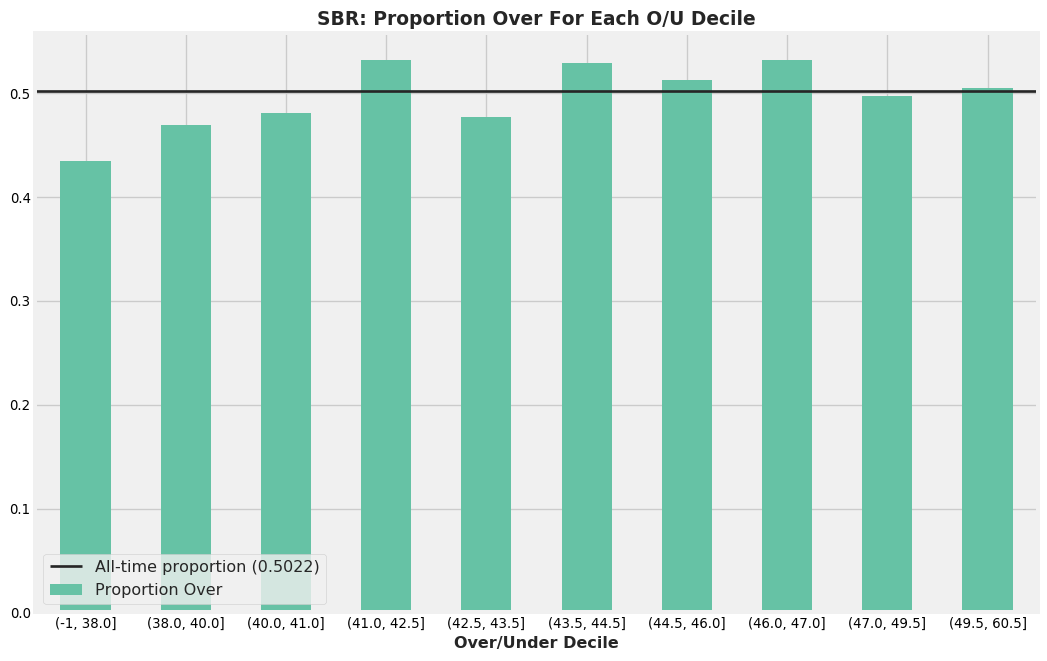

In [26]:
ou_bin_prop = ou_df.withColumn(
        'Over/Under Decile', 
        udf(lambda x: ou_bin_map[x]['Bin'], StringType())('close_ou')
    ).withColumn(
        'decile', 
        udf(lambda x: ou_bin_map[x]['Decile'], StringType())('close_ou')
    ).groupby(['Over/Under Decile','decile'])\
        .pivot('is_close_ou_over')\
        .count()\
        .toPandas()
tot_all = ou_bin_prop[['-1','1']].sum(axis=0)
tot_prop = tot_all['-1'] / tot_all.astype(float).sum()

ou_bin_prop['Proportion Over'] = ou_bin_prop['1'] \
                                    / (ou_bin_prop['-1'] + ou_bin_prop['1'])
ou_bin_prop = ou_bin_prop.set_index('Over/Under Decile')\
                         .sort_values(by='decile')\
                         .drop('decile', axis=1)

tmp = ou_bin_prop.iloc[:3, :].sum()
print 'Over/Unders at 41 and below go over {:.1f}%'\
            .format(tmp['1'].sum() / float(tmp[['-1','1']].sum())*100)

_ = ou_bin_prop[['Proportion Over']].plot(
    kind='bar', rot=0, legend=None,
    title='SBR: Proportion Over For Each O/U Decile'
)
_ = plt.axhline(
    y=tot_prop, color='#262626', linewidth=2,
    label='All-time proportion ({:.4f})'.format(tot_prop)
)
_ = plt.legend(loc=3)

### Form other labels
* #### Goal: 2 rows for each game
* key is (game_id, team_id)
* compute labels as needed
* doesn't work for Over/Under